# Checking OSCURS fortran and python code results

In [18]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.path import Path
import calendar

In [19]:
# Set target year/month
year = 2024
month = 6

In [20]:
# Date utility function
def get_date_config(year, month):
    input_date = f"{year}{str(month).zfill(2)}"
    last_day = calendar.monthrange(year, month)[1]
    time_index = last_day - 1
    month_abbr = calendar.month_abbr[month].upper()
    formatted_title = f"{last_day:02d}-{month_abbr}-{year}"
    return input_date, last_day, time_index, formatted_title

In [21]:
input_date, last_day, time_index, formatted_title = get_date_config(year, month)

In [22]:
# Load datasets
py = xr.open_dataset(f"/Users/madisonrichardson/OSCURS/compare_results/python/oscurstest_{input_date}.nc")
ft = xr.open_dataset(f"/Users/madisonrichardson/OSCURS/compare_results/fortran/erdlasFnOscurs_{input_date}.nc")
if "time_series" in ft.dims:
    ft = ft.rename({"time_series": "time"})

In [23]:
# Extract final time step
p_py = py["pmsl"].isel(time=time_index)
p_ft = ft["pmsl"].isel(time=time_index)
diff = p_py - p_ft

lat = py["lat"].values
lon = py["lon"].values

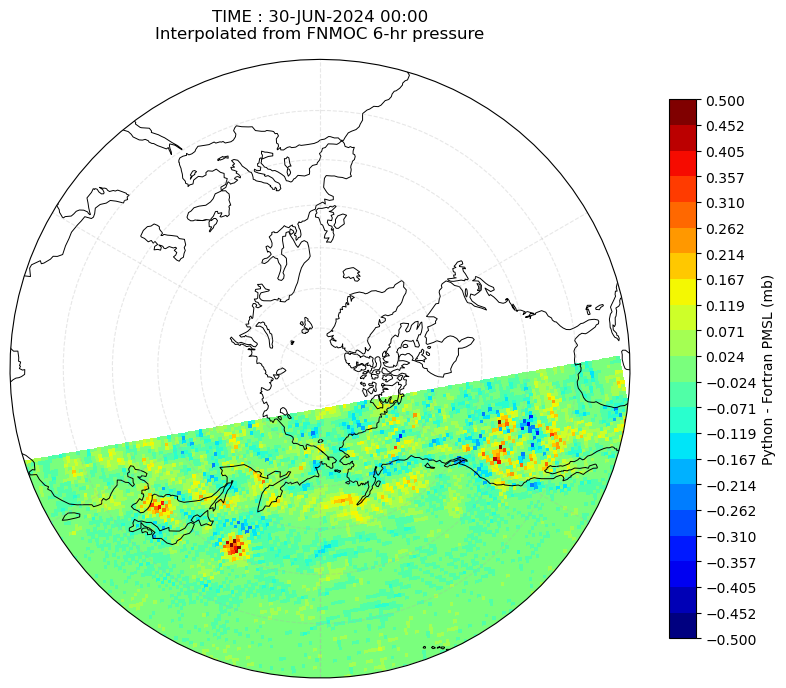

In [24]:
# Plot absolute difference map
bounds = np.linspace(-0.5, 0.5, 22)
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=256)
cmap = plt.get_cmap("jet")

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=180))
ax.set_extent([-180, 180, 20, 90], crs=ccrs.PlateCarree())
c = ax.pcolormesh(lon, lat, diff, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

theta = np.linspace(0, 2 * np.pi, 100)
circle = np.column_stack([np.sin(theta), np.cos(theta)]) * 0.5 + 0.5
path = Path(circle)
ax.set_boundary(path, transform=ax.transAxes)

ax.coastlines(resolution="110m", linewidth=0.7)
ax.gridlines(draw_labels=False, linestyle="--", alpha=0.3)
cb = plt.colorbar(c, orientation="vertical", shrink=0.7, pad=0.05, ticks=bounds)
cb.set_label("Python - Fortran PMSL (mb)")
ax.set_title(f"TIME : {formatted_title} 00:00\nInterpolated from FNMOC 6-hr pressure", fontsize=12, pad=15)
plt.show()

In [25]:
# Compute difference statistics
p_py_all = py["pmsl"]
p_ft_all = ft["pmsl"]
diff_all = p_py_all - p_ft_all

print(f"Max diff: {np.nanmax(diff_all.values):.3f}")
print(f"Mean diff: {np.nanmean(diff_all.values):.3f}")
print(f"Std dev: {np.nanstd(diff_all.values):.3f}")

max_idx = np.nanargmax(np.abs(diff_all.values))
t_idx, y_idx, x_idx = np.unravel_index(max_idx, diff_all.shape)
print(f"Max diff at time={t_idx}, y={y_idx}, x={x_idx}")
print("Python:", p_py_all[t_idx, y_idx, x_idx].values)
print("Fortran:", p_ft_all[t_idx, y_idx, x_idx].values)
print("Abs diff:", abs(p_py_all[t_idx, y_idx, x_idx] - p_ft_all[t_idx, y_idx, x_idx]).values)

Max diff: 1.012
Mean diff: 0.000
Std dev: 0.049
Max diff at time=17, y=14, x=145
Python: 990.0532
Fortran: 989.04114
Abs diff: 1.012085


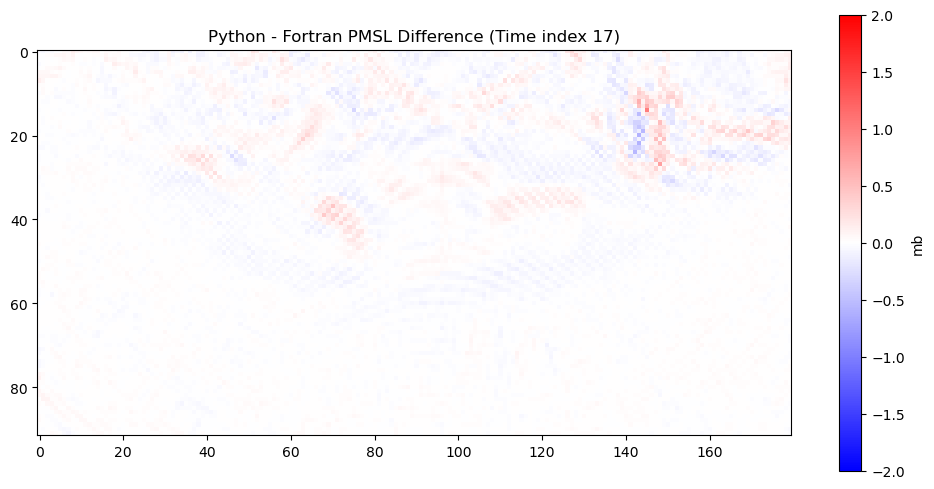

In [26]:
# Plot time slice of max diff
plt.figure(figsize=(10, 5))
plt.imshow(diff_all[t_idx], cmap="bwr", vmin=-2, vmax=2)
plt.title(f"Python - Fortran PMSL Difference (Time index {t_idx})")
plt.colorbar(label="mb")
plt.tight_layout()
plt.show()

Mean % Diff: -0.0000 %
Max % Diff: 0.0667 %
Std Dev % Diff: 0.0045 %


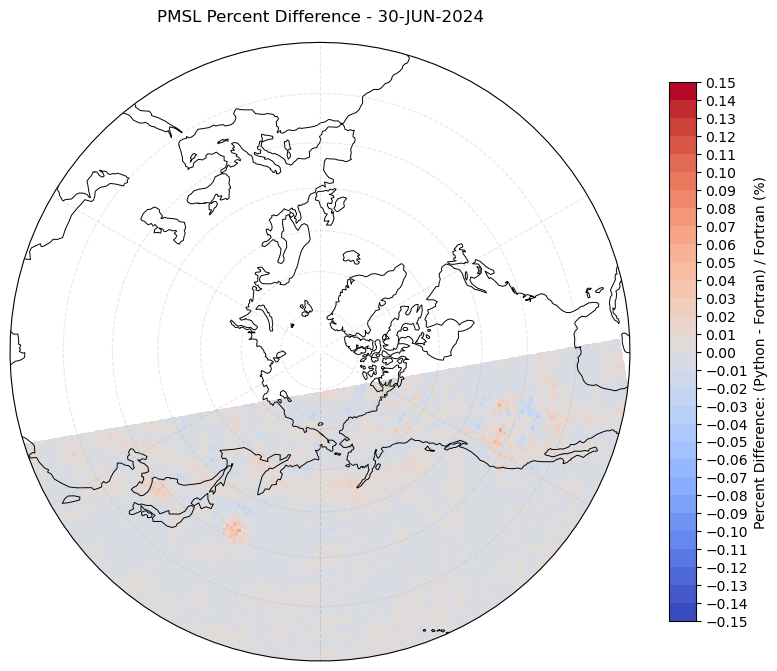

In [27]:
# Percent difference for final day
percent_diff = 100 * (p_py - p_ft) / p_ft

print(f"Mean % Diff: {np.nanmean(percent_diff.values):.4f} %")
print(f"Max % Diff: {np.nanmax(percent_diff.values):.4f} %")
print(f"Std Dev % Diff: {np.nanstd(percent_diff.values):.4f} %")

bounds = np.linspace(-0.15, 0.15, 31)
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=256)
cmap = plt.get_cmap("coolwarm")

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=180))
ax.set_extent([-180, 180, 20, 90], crs=ccrs.PlateCarree())
c = ax.pcolormesh(lon, lat, percent_diff, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

theta = np.linspace(0, 2 * np.pi, 100)
circle = np.column_stack([np.sin(theta), np.cos(theta)]) * 0.5 + 0.5
path = Path(circle)
ax.set_boundary(path, transform=ax.transAxes)

ax.coastlines(resolution="110m", linewidth=0.7)
ax.gridlines(draw_labels=False, linestyle="--", alpha=0.3)
cb = plt.colorbar(c, orientation="vertical", shrink=0.7, pad=0.05, ticks=bounds)
cb.set_label("Percent Difference: (Python - Fortran) / Fortran (%)")
ax.set_title(f"PMSL Percent Difference - {formatted_title}", fontsize=12, pad=15)
plt.show()

In [28]:
# Percent differences for entire month
p_py_all = py["pmsl"]
p_ft_all = ft["pmsl"]
percent_diff_all = 100 * (p_py_all - p_ft_all) / p_ft_all

print(f"Full Month Percent Difference Stats:")
print(f"Mean % Diff: {np.nanmean(percent_diff_all.values):.4f} %")
print(f"Max % Diff: {np.nanmax(percent_diff_all.values):.4f} %")
print(f"Std Dev % Diff: {np.nanstd(percent_diff_all.values):.4f} %")

Full Month Percent Difference Stats:
Mean % Diff: 0.0000 %
Max % Diff: 0.1023 %
Std Dev % Diff: 0.0048 %
